**Table of contents**<a id='toc0_'></a>    
- [Gene Symbol Capture Analysis](#toc1_)    
    - [Combining the annotations from symbol_capture_generation into one table and presenting them in an upset plot](#toc1_1_1_)    
  - [Ortholog Capture Analysis](#toc1_2_)    
    - [Import ortholog_analysis_dfs into notebook](#toc1_2_1_)    
    - [Condense all ortholog_analysis_dfs into one with just a Ortholog column](#toc1_2_2_)    
      - [Put all ortholog_analysis_dfs into a dictionary](#toc1_2_2_1_)    
      - [Import the df that has gene records from NCBI, HGNC, and Ensembl](#toc1_2_2_2_)    
      - [Add the "Species" Match column to the gene record df](#toc1_2_2_3_)    
      - [Using the "Species" Match columns, populate a general "Ortholog" column](#toc1_2_2_4_)    
      - [The df with all of the "Species" Match columns](#toc1_2_2_5_)    
      - [The df with just the "Ortholog" column](#toc1_2_2_6_)    
      - [The df with just the "Ortholog" column and only the True rows](#toc1_2_2_7_)    
    - [How many symbols are otholog symbols?](#toc1_2_3_)    
- [HGNC Previous Symbol Capture Analysis](#toc2_)    
- [FLJ Clone Name Capture Analysis](#toc3_)    
- [Gene Family Symbol Capture Analysis](#toc4_)    
- [Disorder/Disease Symbol Capture Analysis](#toc5_)    
- [Capture Summary](#toc6_)    
    - [Combine the primary gene symbols with the alias symbols to have all gene symbols in one column](#toc6_1_1_)    
    - [Combine the information for the rows with the same primary and alias gene symbols](#toc6_1_2_)    
    - [Create a summary table highliting which symbols have been captured](#toc6_1_3_)    
    - [Data Results](#toc6_1_4_)    
      - [Collisions are treated as unique symbols since they are being characterized in the context of the gene concept they represent](#toc6_1_4_1_)    
      - [The same symbol can represent different relationships for the same gene concept in different sources due to annotation discrepancies](#toc6_1_4_2_)    
      - [% captured shows the amount of gene symbols that are explainable/ have support for why they represent a gene](#toc6_1_4_3_)    
      - [Upset plot: show capture statistics](#toc6_1_4_4_)    
      - [Which gene concepts have different primary gene symbol across the dbs?](#toc6_1_4_5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Gene Symbol Capture Analysis](#toc0_)

### <a id='toc1_1_1_'></a>[Combining the annotations from symbol_capture_generation into one table and presenting them in an upset plot](#toc0_)

The block of code that combines all of the tables into one take a long time to run. Might need to look into making it more efficient. 

In [157]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from upsetplot import UpSet
from upsetplot import generate_counts, plot
from collections import Counter
import matplotlib.pyplot as plt

## <a id='toc1_2_'></a>[Ortholog Capture Analysis](#toc0_)

### <a id='toc1_2_1_'></a>[Import ortholog_analysis_dfs into notebook](#toc0_)

In [158]:
folder_path = "../output/"  
num_files = 10

file_names = [os.path.join(folder_path, f'ortholog_analysis_{i}_df.csv') for i in range(1, num_files + 1)]

ortholog_analysis_dfs = {}

for i, file_name in enumerate(file_names, start=1):
    df = pd.read_csv(file_name, index_col=0)  

    var_name = f'ortholog_analysis_{i}_df'
    
    globals()[var_name] = df

### <a id='toc1_2_2_'></a>[Condense all ortholog_analysis_dfs into one with just a Ortholog column](#toc0_)

#### <a id='toc1_2_2_1_'></a>[Put all ortholog_analysis_dfs into a dictionary](#toc0_)

In [159]:
ortholog_analysis_dfs_list = [
    value for key, value in globals().items()
    if key.startswith('ortholog_analysis')
    and key.endswith('_df')
    and 'summary' not in key
    and any(char.isdigit() for char in key)
    and isinstance(value, pd.DataFrame)
]
ortholog_analysis_dfs_list

[      primary_gene_symbol  alias_symbol         HGNC_ID              ENSG_ID  \
 0              A-GAMMA3'E     A-GAMMA-E           set()                set()   
 1                    A1BG           A1B      {'HGNC:5'}  {'ENSG00000121410'}   
 2                    A1BG           ABG      {'HGNC:5'}  {'ENSG00000121410'}   
 3                    A1BG           GAB      {'HGNC:5'}  {'ENSG00000121410'}   
 4                    A1BG      HYST2477      {'HGNC:5'}  {'ENSG00000121410'}   
 ...                   ...           ...             ...                  ...   
 86593               ZZEF1      FLJ10821  {'HGNC:29027'}  {'ENSG00000074755'}   
 86594               ZZEF1      KIAA0399  {'HGNC:29027'}  {'ENSG00000074755'}   
 86595               ZZEF1          ZZZ4  {'HGNC:29027'}  {'ENSG00000074755'}   
 86596                ZZZ3         ATAC1  {'HGNC:24523'}  {'ENSG00000036549'}   
 86597                ZZZ3  DKFZP564I052  {'HGNC:24523'}  {'ENSG00000036549'}   
 
                      NCBI

#### <a id='toc1_2_2_2_'></a>[Import the df that has gene records from NCBI, HGNC, and Ensembl](#toc0_)

In [160]:
subset_genes_df = pd.read_hdf(
    "../output/subset_genes_df.h5", key='df'
    )
subset_genes_df

,primary_gene_symbol,alias_symbol,HGNC_ID,ENSG_ID,NCBI_ID
0,A-GAMMA3'E,A-GAMMA-E,{},{},{GENE ID:109951028}
1,A1BG,A1B,{HGNC:5},{ENSG00000121410},{GENE ID:1}
2,A1BG,ABG,{HGNC:5},{ENSG00000121410},{GENE ID:1}
3,A1BG,GAB,{HGNC:5},{ENSG00000121410},{GENE ID:1}
4,A1BG,HYST2477,{HGNC:5},{ENSG00000121410},{GENE ID:1}
...,...,...,...,...,...
86593,ZZEF1,FLJ10821,{HGNC:29027},{ENSG00000074755},{GENE ID:23140}
86594,ZZEF1,KIAA0399,{HGNC:29027},{ENSG00000074755},{GENE ID:23140}
86595,ZZEF1,ZZZ4,{HGNC:29027},{ENSG00000074755},{GENE ID:23140}
86596,ZZZ3,ATAC1,{HGNC:24523},{ENSG00000036549},{GENE ID:26009}


#### <a id='toc1_2_2_3_'></a>[Add the "Species" Match column to the gene record df](#toc0_)

In [162]:
ortholog_analysis_df = subset_genes_df.copy()
for df in ortholog_analysis_dfs_list:
    ortholog_columns = df.iloc[:, 5:]
    ortholog_analysis_df = pd.concat([ortholog_analysis_df, ortholog_columns], axis=1)

ortholog_analysis_df.reset_index(drop=True, inplace=True)

In [163]:
ortholog_analysis_df.head()

,primary_gene_symbol,alias_symbol,HGNC_ID,ENSG_ID,NCBI_ID,Abingdon island giant tortoise Match,African ostrich Match,Algerian mouse Match,Alpaca Match,Alpine marmot Match,...,Climbing perch Match,Clown anemonefish Match,Coelacanth Match,Coho salmon Match,Collared flycatcher Match,Common canary Match,Common carp Match,Common wall lizard Match,Common wombat Match,Coquerel's sifaka Match
0,A-GAMMA3'E,A-GAMMA-E,{},{},{GENE ID:109951028},False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,A1BG,A1B,{HGNC:5},{ENSG00000121410},{GENE ID:1},False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,A1BG,ABG,{HGNC:5},{ENSG00000121410},{GENE ID:1},False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,A1BG,GAB,{HGNC:5},{ENSG00000121410},{GENE ID:1},False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,A1BG,HYST2477,{HGNC:5},{ENSG00000121410},{GENE ID:1},False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


#### <a id='toc1_2_2_4_'></a>[Using the "Species" Match columns, populate a general "Ortholog" column](#toc0_)

In [164]:
ortholog_analysis_summary_df = ortholog_analysis_df.copy()

In [165]:
info_columns = ortholog_analysis_summary_df.iloc[:, :5]
boolean_columns = ortholog_analysis_summary_df.iloc[:, 5:]

# Create a new column based on whether there's at least one True (T) in the row
ortholog_analysis_summary_df['Ortholog Match'] = boolean_columns.any(axis=1)

# Create a new column with a list of species (derived from the column names) that have True values
ortholog_analysis_summary_df['Matching Species'] = boolean_columns.apply(
    lambda row: [col.replace(' Match', '') for col, match in row.items() if match], axis=1
)

# Concatenate the info columns and the new 'Ortholog Match' and 'Matching Species' columns
ortholog_analysis_summary_df = pd.concat([info_columns, ortholog_analysis_summary_df[['Ortholog Match', 'Matching Species']]], axis=1)

# Display the updated DataFrame
ortholog_analysis_summary_df

,primary_gene_symbol,alias_symbol,HGNC_ID,ENSG_ID,NCBI_ID,Ortholog Match,Matching Species
0,A-GAMMA3'E,A-GAMMA-E,{},{},{GENE ID:109951028},False,[]
1,A1BG,A1B,{HGNC:5},{ENSG00000121410},{GENE ID:1},False,[]
2,A1BG,ABG,{HGNC:5},{ENSG00000121410},{GENE ID:1},False,[]
3,A1BG,GAB,{HGNC:5},{ENSG00000121410},{GENE ID:1},False,[]
4,A1BG,HYST2477,{HGNC:5},{ENSG00000121410},{GENE ID:1},False,[]
...,...,...,...,...,...,...,...
86593,ZZEF1,FLJ10821,{HGNC:29027},{ENSG00000074755},{GENE ID:23140},False,[]
86594,ZZEF1,KIAA0399,{HGNC:29027},{ENSG00000074755},{GENE ID:23140},False,[]
86595,ZZEF1,ZZZ4,{HGNC:29027},{ENSG00000074755},{GENE ID:23140},False,[]
86596,ZZZ3,ATAC1,{HGNC:24523},{ENSG00000036549},{GENE ID:26009},False,[]


In [184]:
ortholog_analysis_summary_df[ortholog_analysis_summary_df["Ortholog Match"]]

,primary_gene_symbol,alias_symbol,HGNC_ID,ENSG_ID,NCBI_ID,Ortholog Match,Matching Species
41,AAAS,ALADIN,{HGNC:13666},{ENSG00000094914},{GENE ID:8086},True,[Arabian camel]
45,AACS,SUR-5,{HGNC:21298},{ENSG00000081760},{GENE ID:65985},True,"[Caenorhabditis elegans (Nematode, N2)]"
73,AARS1,AARS,{HGNC:20},{ENSG00000090861},{GENE ID:16},True,"[American bison, Channel bull blenny]"
430,ABI2,ABI2B,{HGNC:24011},{ENSG00000138443},{GENE ID:10152},True,"[Barramundi perch, Burton's mouthbrooder, Chan..."
445,ABITRAM,FAM206A,{HGNC:1364},{ENSG00000119328},{GENE ID:54942},True,[Chicken]
...,...,...,...,...,...,...,...
86444,ZPBP,ZPBP1,{HGNC:15662},{ENSG00000042813},{GENE ID:11055},True,[Chicken]
86448,ZPR1,ZNF259,{HGNC:13051},{ENSG00000109917},{GENE ID:8882},True,[Armadillo]
86572,ZUP1,ZUFSP,{HGNC:21224},{ENSG00000153975},{GENE ID:221302},True,[American bison]
86588,ZYG11A,ZYG11,{HGNC:32058},{ENSG00000203995},{GENE ID:440590},True,"[Amazon molly, Asian bonytongue, Atlantic cod,..."


#### <a id='toc1_2_2_5_'></a>[The df with all of the "Species" Match columns](#toc0_)

In [185]:
ortholog_analysis_df.to_csv(
    "../output/ortholog_analysis_df.csv", index=True
)

#### <a id='toc1_2_2_6_'></a>[The df with just the "Ortholog" column](#toc0_)

In [186]:
ortholog_analysis_summary_df.to_csv(
    "../output/ortholog_analysis_summary_df.csv", index=True
)

#### <a id='toc1_2_2_7_'></a>[The df with just the "Ortholog" column and only the True rows](#toc0_)

In [188]:
ortholog_analysis_summary_match_df = ortholog_analysis_summary_df[ortholog_analysis_summary_df['Ortholog Match']]

note: ugh. Calmbp1 is the expired mouse name so it doesnt show up

In [189]:
ortholog_analysis_df.loc[
    ortholog_analysis_df["alias_symbol"] == "CALMBP1"
]

,primary_gene_symbol,alias_symbol,HGNC_ID,ENSG_ID,NCBI_ID,Abingdon island giant tortoise Match,African ostrich Match,Algerian mouse Match,Alpaca Match,Alpine marmot Match,...,Climbing perch Match,Clown anemonefish Match,Coelacanth Match,Coho salmon Match,Collared flycatcher Match,Common canary Match,Common carp Match,Common wall lizard Match,Common wombat Match,Coquerel's sifaka Match
4480,ASPM,CALMBP1,{HGNC:19048},{ENSG00000066279},{GENE ID:259266},False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [190]:
ortholog_analysis_summary_df.loc[
    ortholog_analysis_summary_df["alias_symbol"] == "CALMBP1"
]

,primary_gene_symbol,alias_symbol,HGNC_ID,ENSG_ID,NCBI_ID,Ortholog Match,Matching Species
4480,ASPM,CALMBP1,{HGNC:19048},{ENSG00000066279},{GENE ID:259266},False,[]


### <a id='toc1_2_3_'></a>[How many symbols are ortholog symbols?](#toc0_)

In [191]:
ortholog_analysis_summary_df.value_counts(subset= "Ortholog Match")

Ortholog Match
False    85549
True      1049
Name: count, dtype: int64

# <a id='toc2_'></a>[HGNC Previous Symbol Capture Analysis](#toc0_)

In [192]:
previous_symbol_analysis_df = pd.read_hdf(
    "../output/previous_symbol_analysis_df.h5", key='df'
    )
previous_symbol_analysis_df

,primary_gene_symbol,alias_symbol,HGNC_ID,ENSG_ID,NCBI_ID,Previous Symbol Match
0,A-GAMMA3'E,A-GAMMA-E,{},{},{GENE ID:109951028},False
1,A1BG,A1B,{HGNC:5},{ENSG00000121410},{GENE ID:1},False
2,A1BG,ABG,{HGNC:5},{ENSG00000121410},{GENE ID:1},False
3,A1BG,GAB,{HGNC:5},{ENSG00000121410},{GENE ID:1},False
4,A1BG,HYST2477,{HGNC:5},{ENSG00000121410},{GENE ID:1},False
...,...,...,...,...,...,...
86593,ZZEF1,FLJ10821,{HGNC:29027},{ENSG00000074755},{GENE ID:23140},False
86594,ZZEF1,KIAA0399,{HGNC:29027},{ENSG00000074755},{GENE ID:23140},False
86595,ZZEF1,ZZZ4,{HGNC:29027},{ENSG00000074755},{GENE ID:23140},False
86596,ZZZ3,ATAC1,{HGNC:24523},{ENSG00000036549},{GENE ID:26009},False


Just the true rows

In [193]:
previous_symbol_match_subset_genes_df = pd.read_hdf(
    "../output/previous_symbol_match_subset_genes_df.h5", key='df'
    )
previous_symbol_match_subset_genes_df

,primary_gene_symbol,alias_symbol,HGNC_ID,ENSG_ID,NCBI_ID,Previous Symbol Match
5,A1BG-AS1,A1BG-AS,{HGNC:37133},{ENSG00000268895},{GENE ID:503538},True
6,A1BG-AS1,A1BGAS,{HGNC:37133},{ENSG00000268895},{GENE ID:503538},True
8,A1BG-AS1,NCRNA00181,{HGNC:37133},{ENSG00000268895},{GENE ID:503538},True
18,A2ML1,CPAMD9,{HGNC:23336},{ENSG00000166535},{GENE ID:144568},True
22,A2MP1,A2MP,{HGNC:8},"{ENSG00000256069, ENSG00000291190}","{GENE ID:3, GENE ID:124903067}",True
...,...,...,...,...,...,...
86566,ZSWIM8,KIAA0913,{HGNC:23528},{ENSG00000214655},{GENE ID:23053},True
86567,ZSWIM9,C19ORF68,{HGNC:34495},{ENSG00000185453},{GENE ID:374920},True
86569,ZUP1,C6ORF113,{HGNC:21224},{ENSG00000153975},{GENE ID:221302},True
86572,ZUP1,ZUFSP,{HGNC:21224},{ENSG00000153975},{GENE ID:221302},True


# <a id='toc3_'></a>[FLJ Clone Name Capture Analysis](#toc0_)

In [194]:
clone_symbol_analysis_df = pd.read_hdf(
    "../output/clone_symbol_analysis_df.h5", key='df'
    )
clone_symbol_analysis_df

,primary_gene_symbol,alias_symbol,HGNC_ID,ENSG_ID,NCBI_ID,Clone Symbol Match
0,A-GAMMA3'E,A-GAMMA-E,{},{},{GENE ID:109951028},False
1,A1BG,A1B,{HGNC:5},{ENSG00000121410},{GENE ID:1},False
2,A1BG,ABG,{HGNC:5},{ENSG00000121410},{GENE ID:1},False
3,A1BG,GAB,{HGNC:5},{ENSG00000121410},{GENE ID:1},False
4,A1BG,HYST2477,{HGNC:5},{ENSG00000121410},{GENE ID:1},False
...,...,...,...,...,...,...
86593,ZZEF1,FLJ10821,{HGNC:29027},{ENSG00000074755},{GENE ID:23140},True
86594,ZZEF1,KIAA0399,{HGNC:29027},{ENSG00000074755},{GENE ID:23140},False
86595,ZZEF1,ZZZ4,{HGNC:29027},{ENSG00000074755},{GENE ID:23140},False
86596,ZZZ3,ATAC1,{HGNC:24523},{ENSG00000036549},{GENE ID:26009},False


In [195]:
clone_symbol_match_subset_genes_df = pd.read_hdf(
    "../output/clone_symbol_match_subset_genes_df.h5", key='df'
    )
clone_symbol_match_subset_genes_df

,primary_gene_symbol,alias_symbol,HGNC_ID,ENSG_ID,NCBI_ID,Clone Symbol Match
7,A1BG-AS1,FLJ23569,{HGNC:37133},{ENSG00000268895},{GENE ID:503538},True
19,A2ML1,FLJ25179,{HGNC:23336},{ENSG00000166535},{GENE ID:144568},True
44,AACS,FLJ12389,{HGNC:21298},{ENSG00000081760},{GENE ID:65985},True
55,AAGAB,FLJ11506,{HGNC:25662},{ENSG00000103591},{GENE ID:79719},True
64,AAMDC,FLJ21035,{HGNC:30205},{ENSG00000087884},{GENE ID:28971},True
...,...,...,...,...,...,...
86557,ZSWIM4,FLJ12221,{HGNC:25704},"{ENSG00000288360, ENSG00000132003}",{GENE ID:65249},True
86575,ZWILCH,FLJ10036,{HGNC:25468},{ENSG00000174442},{GENE ID:55055},True
86585,ZXDC,FLJ13861,{HGNC:28160},{ENSG00000070476},{GENE ID:79364},True
86589,ZYG11B,FLJ13456,{HGNC:25820},{ENSG00000162378},{GENE ID:79699},True


# <a id='toc4_'></a>[Gene Family Symbol Capture Analysis](#toc0_)

In [196]:
gene_group_analysis_df = pd.read_hdf(
    "../output/gene_group_analysis_df.h5", key='df'
    )
gene_group_analysis_df

,primary_gene_symbol,alias_symbol,HGNC_ID,ENSG_ID,NCBI_ID,Prefix Gene Group Symbol Match,Matching Abbreviation
0,A-GAMMA3'E,A-GAMMA-E,{},{},{GENE ID:109951028},False,
1,A1BG,A1B,{HGNC:5},{ENSG00000121410},{GENE ID:1},False,
2,A1BG,ABG,{HGNC:5},{ENSG00000121410},{GENE ID:1},False,
3,A1BG,GAB,{HGNC:5},{ENSG00000121410},{GENE ID:1},False,
4,A1BG,HYST2477,{HGNC:5},{ENSG00000121410},{GENE ID:1},False,
...,...,...,...,...,...,...,...
86593,ZZEF1,FLJ10821,{HGNC:29027},{ENSG00000074755},{GENE ID:23140},False,
86594,ZZEF1,KIAA0399,{HGNC:29027},{ENSG00000074755},{GENE ID:23140},False,
86595,ZZEF1,ZZZ4,{HGNC:29027},{ENSG00000074755},{GENE ID:23140},True,ZZZ
86596,ZZZ3,ATAC1,{HGNC:24523},{ENSG00000036549},{GENE ID:26009},True,ATAC


In [197]:
gene_group_prefix_match_subset_genes_df = pd.read_hdf(
    "../output/gene_group_prefix_match_subset_genes_df.h5", key='df'
    )
gene_group_prefix_match_subset_genes_df

,primary_gene_symbol,alias_symbol,HGNC_ID,ENSG_ID,NCBI_ID,Prefix Gene Group Symbol Match,Matching Abbreviation
43,AACS,ACSF1,{HGNC:21298},{ENSG00000081760},{GENE ID:65985},True,ACS
90,AASDH,ACSF4,{HGNC:23993},{ENSG00000157426},{GENE ID:132949},True,ACS
112,AATK,PPP1R77,{HGNC:21},{ENSG00000181409},{GENE ID:9625},True,PPP1R
127,ABCA11P,ABCA11,{HGNC:31},"{ENSG00000293360, ENSG00000251595}",{GENE ID:79963},True,ABCA
140,ABCA17P,ABCA17,{HGNC:32972},{ENSG00000293423},{GENE ID:650655},True,ABCA
...,...,...,...,...,...,...,...
86584,ZXDB,ZNF905,{HGNC:13199},{ENSG00000198455},{GENE ID:158586},True,ZNF
86588,ZYG11A,ZYG11,{HGNC:32058},{ENSG00000203995},{GENE ID:440590},True,ZYG11
86590,ZYG11B,ZYG11,{HGNC:25820},{ENSG00000162378},{GENE ID:79699},True,ZYG11
86595,ZZEF1,ZZZ4,{HGNC:29027},{ENSG00000074755},{GENE ID:23140},True,ZZZ


# <a id='toc5_'></a>[Disorder/Disease Symbol Capture Analysis](#toc0_)

In [198]:
disease_analysis_df = pd.read_hdf(
    "../output/disease_analysis_df.h5", key='df'
    )
disease_analysis_df

,primary_gene_symbol,alias_symbol,HGNC_ID,ENSG_ID,NCBI_ID,Prefix Disease Symbol Match,Matching Phenotype Symbol
0,A-GAMMA3'E,A-GAMMA-E,{},{},{GENE ID:109951028},False,
1,A1BG,A1B,{HGNC:5},{ENSG00000121410},{GENE ID:1},False,
2,A1BG,ABG,{HGNC:5},{ENSG00000121410},{GENE ID:1},False,
3,A1BG,GAB,{HGNC:5},{ENSG00000121410},{GENE ID:1},False,
4,A1BG,HYST2477,{HGNC:5},{ENSG00000121410},{GENE ID:1},False,
...,...,...,...,...,...,...,...
86593,ZZEF1,FLJ10821,{HGNC:29027},{ENSG00000074755},{GENE ID:23140},False,
86594,ZZEF1,KIAA0399,{HGNC:29027},{ENSG00000074755},{GENE ID:23140},False,
86595,ZZEF1,ZZZ4,{HGNC:29027},{ENSG00000074755},{GENE ID:23140},False,
86596,ZZZ3,ATAC1,{HGNC:24523},{ENSG00000036549},{GENE ID:26009},False,


In [202]:
disease_prefix_match_subset_genes_df = pd.read_hdf(
    "../output/disease_prefix_match_subset_genes_df.h5", key='df'
    )
disease_prefix_match_subset_genes_df

,primary_gene_symbol,alias_symbol,HGNC_ID,ENSG_ID,NCBI_ID,Prefix Disease Symbol Match,Matching Phenotype Symbol
14,A2M,A2MD,{HGNC:7},{ENSG00000175899},{GENE ID:2},True,A2MD
20,A2ML1,OMS,{HGNC:23336},{ENSG00000166535},{GENE ID:144568},True,OMS
38,AAAS,AAASB,{HGNC:13666},{ENSG00000094914},{GENE ID:8086},True,AAAS
58,AAGAB,PPKP1,{HGNC:25662},{ENSG00000103591},{GENE ID:79719},True,PPKP1
59,AAGAB,PPKP1A,{HGNC:25662},{ENSG00000103591},{GENE ID:79719},True,PPKP1A
...,...,...,...,...,...,...,...
86480,ZSCAN10,OFNS,{HGNC:12997},{ENSG00000130182},{GENE ID:84891},True,OFNS
86559,ZSWIM6,AFND,{HGNC:29316},{ENSG00000130449},{GENE ID:57688},True,AFND
86561,ZSWIM6,NEDMAGA,{HGNC:29316},{ENSG00000130449},{GENE ID:57688},True,NEDMAGA
86562,ZSWIM7,ODG10,{HGNC:26993},{ENSG00000214941},{GENE ID:125150},True,ODG10


# <a id='toc6_'></a>[Capture Summary](#toc0_)

### <a id='toc6_1_1_'></a>[Combine the primary gene symbols with the alias symbols to have all gene symbols in one column](#toc0_)

In [209]:
df = subset_genes_df.copy()
df_primary = df[['primary_gene_symbol', 'HGNC_ID', 'ENSG_ID', 'NCBI_ID']].copy()
df_primary['gene_symbols'] = df_primary['primary_gene_symbol']
df_primary

,primary_gene_symbol,HGNC_ID,ENSG_ID,NCBI_ID,gene_symbols
0,A-GAMMA3'E,{},{},{GENE ID:109951028},A-GAMMA3'E
1,A1BG,{HGNC:5},{ENSG00000121410},{GENE ID:1},A1BG
2,A1BG,{HGNC:5},{ENSG00000121410},{GENE ID:1},A1BG
3,A1BG,{HGNC:5},{ENSG00000121410},{GENE ID:1},A1BG
4,A1BG,{HGNC:5},{ENSG00000121410},{GENE ID:1},A1BG
...,...,...,...,...,...
86593,ZZEF1,{HGNC:29027},{ENSG00000074755},{GENE ID:23140},ZZEF1
86594,ZZEF1,{HGNC:29027},{ENSG00000074755},{GENE ID:23140},ZZEF1
86595,ZZEF1,{HGNC:29027},{ENSG00000074755},{GENE ID:23140},ZZEF1
86596,ZZZ3,{HGNC:24523},{ENSG00000036549},{GENE ID:26009},ZZZ3


In [210]:
df_aliases = df[['primary_gene_symbol', 'alias_symbol', 'HGNC_ID', 'ENSG_ID', 'NCBI_ID']].copy()
df_aliases['gene_symbols'] = df_aliases['alias_symbol']
df_aliases

,primary_gene_symbol,alias_symbol,HGNC_ID,ENSG_ID,NCBI_ID,gene_symbols
0,A-GAMMA3'E,A-GAMMA-E,{},{},{GENE ID:109951028},A-GAMMA-E
1,A1BG,A1B,{HGNC:5},{ENSG00000121410},{GENE ID:1},A1B
2,A1BG,ABG,{HGNC:5},{ENSG00000121410},{GENE ID:1},ABG
3,A1BG,GAB,{HGNC:5},{ENSG00000121410},{GENE ID:1},GAB
4,A1BG,HYST2477,{HGNC:5},{ENSG00000121410},{GENE ID:1},HYST2477
...,...,...,...,...,...,...
86593,ZZEF1,FLJ10821,{HGNC:29027},{ENSG00000074755},{GENE ID:23140},FLJ10821
86594,ZZEF1,KIAA0399,{HGNC:29027},{ENSG00000074755},{GENE ID:23140},KIAA0399
86595,ZZEF1,ZZZ4,{HGNC:29027},{ENSG00000074755},{GENE ID:23140},ZZZ4
86596,ZZZ3,ATAC1,{HGNC:24523},{ENSG00000036549},{GENE ID:26009},ATAC1


In [211]:
df_combined = pd.concat([df_primary, df_aliases], ignore_index=True)
df_combined.drop(["alias_symbol"], axis=1, inplace=True)
df_combined

,primary_gene_symbol,HGNC_ID,ENSG_ID,NCBI_ID,gene_symbols
0,A-GAMMA3'E,{},{},{GENE ID:109951028},A-GAMMA3'E
1,A1BG,{HGNC:5},{ENSG00000121410},{GENE ID:1},A1BG
2,A1BG,{HGNC:5},{ENSG00000121410},{GENE ID:1},A1BG
3,A1BG,{HGNC:5},{ENSG00000121410},{GENE ID:1},A1BG
4,A1BG,{HGNC:5},{ENSG00000121410},{GENE ID:1},A1BG
...,...,...,...,...,...
173191,ZZEF1,{HGNC:29027},{ENSG00000074755},{GENE ID:23140},FLJ10821
173192,ZZEF1,{HGNC:29027},{ENSG00000074755},{GENE ID:23140},KIAA0399
173193,ZZEF1,{HGNC:29027},{ENSG00000074755},{GENE ID:23140},ZZZ4
173194,ZZZ3,{HGNC:24523},{ENSG00000036549},{GENE ID:26009},ATAC1


In [213]:
df_combined.loc[df_combined["primary_gene_symbol"]== "A1BG"]

,primary_gene_symbol,HGNC_ID,ENSG_ID,NCBI_ID,gene_symbols
1,A1BG,{HGNC:5},{ENSG00000121410},{GENE ID:1},A1BG
2,A1BG,{HGNC:5},{ENSG00000121410},{GENE ID:1},A1BG
3,A1BG,{HGNC:5},{ENSG00000121410},{GENE ID:1},A1BG
4,A1BG,{HGNC:5},{ENSG00000121410},{GENE ID:1},A1BG
86599,A1BG,{HGNC:5},{ENSG00000121410},{GENE ID:1},A1B
86600,A1BG,{HGNC:5},{ENSG00000121410},{GENE ID:1},ABG
86601,A1BG,{HGNC:5},{ENSG00000121410},{GENE ID:1},GAB
86602,A1BG,{HGNC:5},{ENSG00000121410},{GENE ID:1},HYST2477


In [214]:
df_combined.loc[df_combined["gene_symbols"]== "A1B"]

,primary_gene_symbol,HGNC_ID,ENSG_ID,NCBI_ID,gene_symbols
86599,A1BG,{HGNC:5},{ENSG00000121410},{GENE ID:1},A1B
158030,SNTB1,{HGNC:11168},{ENSG00000172164},{GENE ID:6641},A1B


### <a id='toc6_1_2_'></a>[Combine the information for the rows with the same primary and alias gene symbols](#toc0_)

In [217]:
def merge_sets(group):
    """ Merge information for groups of rows

    :param group: rows with the same values for selected columns
    return: a df of gene records
    """
        
    merged_HGNC = set()
    merged_ENSG = set()
    merged_NCBI = set()
    merged_sources = set()

    # iterate over the group to merge information, unions to combine sets
    for _, row in group.iterrows():
        merged_HGNC |= row['HGNC_ID']  
        merged_ENSG |= row['ENSG_ID']
        merged_NCBI |= row['NCBI_ID'] 

    # return a new row with the merged information
    return pd.Series({
        'HGNC_ID': merged_HGNC,
        'ENSG_ID': merged_ENSG,
        'NCBI_ID': merged_NCBI,
        'primary_gene_symbol': group['primary_gene_symbol'].iloc[0],  # all rows in the group should have the same value for primary gene symbol and alias
        'gene_symbols': group['gene_symbols'].iloc[0]  
    })


In [219]:
df_combined = df_combined.groupby(['primary_gene_symbol', 'gene_symbols']).apply(merge_sets).reset_index(drop=True)
df_combined

/var/folders/vt/znzp_c6s02q6kjcmqfk0cb500000gq/T/ipykernel_73644/1261017275.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_combined = df_combined.groupby(['primary_gene_symbol', 'gene_symbols']).apply(merge_sets).reset_index(drop=True)


,HGNC_ID,ENSG_ID,NCBI_ID,primary_gene_symbol,gene_symbols
0,{},{},{GENE ID:109951028},A-GAMMA3'E,A-GAMMA-E
1,{},{},{GENE ID:109951028},A-GAMMA3'E,A-GAMMA3'E
2,{HGNC:5},{ENSG00000121410},{GENE ID:1},A1BG,A1B
3,{HGNC:5},{ENSG00000121410},{GENE ID:1},A1BG,A1BG
4,{HGNC:5},{ENSG00000121410},{GENE ID:1},A1BG,ABG
...,...,...,...,...,...
116329,{HGNC:29027},{ENSG00000074755},{GENE ID:23140},ZZEF1,ZZEF1
116330,{HGNC:29027},{ENSG00000074755},{GENE ID:23140},ZZEF1,ZZZ4
116331,{HGNC:24523},{ENSG00000036549},{GENE ID:26009},ZZZ3,ATAC1
116332,{HGNC:24523},{ENSG00000036549},{GENE ID:26009},ZZZ3,DKFZP564I052


### <a id='toc6_1_3_'></a>[Create a summary table highliting which symbols have been captured](#toc0_)

If this section is commented out, it is because I wanted to stop myself from rerunning it. It takes a long time to run and downstream code depends on it. 

In [220]:
# summary_df = df_combined.copy()

In [227]:
# relationship_dfs = [
#     {"df": previous_symbol_match_subset_genes_df, "type": "HGNC Previous Symbol", "check": 
#      lambda row, df: any(
#         (row['primary_gene_symbol'] == df_row['primary_gene_symbol']) and
#         (row['gene_symbols'] == df_row['alias_symbol'])
#         for _, df_row in df.iterrows()
#     )},
#     {"df": ortholog_analysis_summary_match_df, "type": "Ortholog", "check": 
#           lambda row, df: any(
#         (row['primary_gene_symbol'] == df_row['primary_gene_symbol']) and
#         (row['gene_symbols'] == df_row['alias_symbol'])
#         for _, df_row in df.iterrows()
#     )},
#     {"df": clone_symbol_match_subset_genes_df, "type": "Clone Symbol", "check": 
#      lambda row, df: any(
#         (row['primary_gene_symbol'] == df_row['primary_gene_symbol']) and
#         (row['gene_symbols'] == df_row['alias_symbol'])
#         for _, df_row in df.iterrows()
#     )},
#     {"df": gene_group_prefix_match_subset_genes_df, "type": "Prefix Gene Group Symbol", "check": 
#      lambda row, df: any(
#         (row['primary_gene_symbol'] == df_row['primary_gene_symbol']) and
#         (row['gene_symbols'] == df_row['alias_symbol'])
#         for _, df_row in df.iterrows()
#     )},
#     {"df": disease_prefix_match_subset_genes_df, "type": "Prefix Disease Symbol", "check": 
#      lambda row, df: any(
#         (row['primary_gene_symbol'] == df_row['primary_gene_symbol']) and
#         (row['gene_symbols'] == df_row['alias_symbol'])
#         for _, df_row in df.iterrows()
#     )},      
#     {"df": None, "type": "Primary Gene Symbol", "check": lambda row, df: row['gene_symbols'] == row['primary_gene_symbol'] and row['gene_symbols'] in primary_gene_symbol_set}
# ]
# # Add the 'classified' column to df_main
# def capture_row(row):
#     classifications = []
#     for relationship_df in relationship_dfs:
#         if relationship_df["check"](row, relationship_df["df"]):
#             classifications.append(relationship_df["type"])
#     return classifications

# tqdm.pandas()

# summary_df['relationships'] = summary_df.progress_apply(capture_row, axis=1)
# summary_df['captured'] = summary_df['relationships'].apply(lambda x: 'T' if x else 'F')
# summary_df['captured as:'] = summary_df['relationships'].apply(lambda x: ', '.join(x) if x else None)

# # Drop the intermediate classifications list if not needed
# summary_df.drop(columns=["relationships"], inplace=True)

# summary_df


100%|██████████| 116334/116334 [20:15:14<00:00,  1.60it/s]     


,HGNC_ID,ENSG_ID,NCBI_ID,primary_gene_symbol,gene_symbols,captured,captured as:
0,{},{},{GENE ID:109951028},A-GAMMA3'E,A-GAMMA-E,F,None
1,{},{},{GENE ID:109951028},A-GAMMA3'E,A-GAMMA3'E,T,Primary Gene Symbol
2,{HGNC:5},{ENSG00000121410},{GENE ID:1},A1BG,A1B,F,None
3,{HGNC:5},{ENSG00000121410},{GENE ID:1},A1BG,A1BG,T,Primary Gene Symbol
4,{HGNC:5},{ENSG00000121410},{GENE ID:1},A1BG,ABG,F,None
...,...,...,...,...,...,...,...
116329,{HGNC:29027},{ENSG00000074755},{GENE ID:23140},ZZEF1,ZZEF1,T,Primary Gene Symbol
116330,{HGNC:29027},{ENSG00000074755},{GENE ID:23140},ZZEF1,ZZZ4,T,Prefix Gene Group Symbol
116331,{HGNC:24523},{ENSG00000036549},{GENE ID:26009},ZZZ3,ATAC1,T,Prefix Gene Group Symbol
116332,{HGNC:24523},{ENSG00000036549},{GENE ID:26009},ZZZ3,DKFZP564I052,F,None


In [248]:
# summary_df.to_csv(
#     "../output/summary_df.csv", index=True
# )

In [249]:
# summary_df.to_hdf(
#     "../output/summary_df.h5", key='df', mode='w'
# )

/var/folders/vt/znzp_c6s02q6kjcmqfk0cb500000gq/T/ipykernel_73644/3243150398.py:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['HGNC_ID', 'ENSG_ID', 'NCBI_ID', 'primary_gene_symbol', 'gene_symbols',
       'captured', 'captured as:'],
      dtype='object')]

  summary_df.to_hdf(


In [250]:
capture_df = pd.read_hdf(
    "../output/summary_df.h5", key='df'
    )
capture_df

,HGNC_ID,ENSG_ID,NCBI_ID,primary_gene_symbol,gene_symbols,captured,captured as:
0,{},{},{GENE ID:109951028},A-GAMMA3'E,A-GAMMA-E,F,None
1,{},{},{GENE ID:109951028},A-GAMMA3'E,A-GAMMA3'E,T,Primary Gene Symbol
2,{HGNC:5},{ENSG00000121410},{GENE ID:1},A1BG,A1B,F,None
3,{HGNC:5},{ENSG00000121410},{GENE ID:1},A1BG,A1BG,T,Primary Gene Symbol
4,{HGNC:5},{ENSG00000121410},{GENE ID:1},A1BG,ABG,F,None
...,...,...,...,...,...,...,...
116329,{HGNC:29027},{ENSG00000074755},{GENE ID:23140},ZZEF1,ZZEF1,T,Primary Gene Symbol
116330,{HGNC:29027},{ENSG00000074755},{GENE ID:23140},ZZEF1,ZZZ4,T,Prefix Gene Group Symbol
116331,{HGNC:24523},{ENSG00000036549},{GENE ID:26009},ZZZ3,ATAC1,T,Prefix Gene Group Symbol
116332,{HGNC:24523},{ENSG00000036549},{GENE ID:26009},ZZZ3,DKFZP564I052,F,None


In [251]:
capture_df.head(50)

,HGNC_ID,ENSG_ID,NCBI_ID,primary_gene_symbol,gene_symbols,captured,captured as:
0,{},{},{GENE ID:109951028},A-GAMMA3'E,A-GAMMA-E,F,None
1,{},{},{GENE ID:109951028},A-GAMMA3'E,A-GAMMA3'E,T,Primary Gene Symbol
2,{HGNC:5},{ENSG00000121410},{GENE ID:1},A1BG,A1B,F,None
3,{HGNC:5},{ENSG00000121410},{GENE ID:1},A1BG,A1BG,T,Primary Gene Symbol
4,{HGNC:5},{ENSG00000121410},{GENE ID:1},A1BG,ABG,F,None
5,{HGNC:5},{ENSG00000121410},{GENE ID:1},A1BG,GAB,F,None
6,{HGNC:5},{ENSG00000121410},{GENE ID:1},A1BG,HYST2477,F,None
7,{HGNC:37133},{ENSG00000268895},{GENE ID:503538},A1BG-AS1,A1BG-AS,T,HGNC Previous Symbol
8,{HGNC:37133},{ENSG00000268895},{GENE ID:503538},A1BG-AS1,A1BG-AS1,T,Primary Gene Symbol
9,{HGNC:37133},{ENSG00000268895},{GENE ID:503538},A1BG-AS1,A1BGAS,T,HGNC Previous Symbol


In [252]:
capture_df.loc[capture_df["captured as:"] == "HGNC Previous Symbol, Clone Symbol"]

,HGNC_ID,ENSG_ID,NCBI_ID,primary_gene_symbol,gene_symbols,captured,captured as:
59056,{HGNC:1274},{ENSG00000215386},{GENE ID:388815},MIR99AHG,FLJ38295,T,"HGNC Previous Symbol, Clone Symbol"


### <a id='toc6_1_4_'></a>[Data Results](#toc0_)

#### <a id='toc6_1_4_1_'></a>[Collisions are treated as unique symbols since they are being characterized in the context of the gene concept they represent](#toc0_)

In [253]:
capture_df.loc[capture_df["gene_symbols"]=="TR2"]

,HGNC_ID,ENSG_ID,NCBI_ID,primary_gene_symbol,gene_symbols,captured,captured as:
21097,{HGNC:29899},{ENSG00000121690},{GENE ID:91614},DEPDC7,TR2,F,None
65610,{HGNC:7971},{ENSG00000120798},{GENE ID:7181},NR2C1,TR2,T,HGNC Previous Symbol
100088,{HGNC:14905},{ENSG00000179002},{GENE ID:80834},TAS1R2,TR2,F,None
103684,{HGNC:11912},"{ENSG00000157873, ENSG00000273936}",{GENE ID:8764},TNFRSF14,TR2,F,None
109508,{HGNC:20667},{ENSG00000197763},{GENE ID:114112},TXNRD3,TR2,F,None


#### <a id='toc6_1_4_2_'></a>[The same symbol can represent different relationships for the same gene concept in different sources due to annotation discrepancies](#toc0_)

In [254]:
capture_df.loc[capture_df["gene_symbols"]=="ABHD11-AS1"]

,HGNC_ID,ENSG_ID,NCBI_ID,primary_gene_symbol,gene_symbols,captured,captured as:
8023,{HGNC:18289},{ENSG00000225969},{GENE ID:171022},BICDL3P,ABHD11-AS1,T,HGNC Previous Symbol


#### <a id='toc6_1_4_3_'></a>[% captured shows the amount of gene symbols that are explainable/ have support for why they represent a gene](#toc0_)

In [255]:
capture_df["captured"].value_counts()

captured
T    62399
F    53935
Name: count, dtype: int64

In [256]:
capture_df.loc[capture_df["captured as:"]=="HGNC Previous Symbol, Prefix Gene Group Symbol, Prefix Disease Symbol"]

,HGNC_ID,ENSG_ID,NCBI_ID,primary_gene_symbol,gene_symbols,captured,captured as:
8603,{HGNC:1101},{ENSG00000139618},{GENE ID:675},BRCA2,FANCD1,T,"HGNC Previous Symbol, Prefix Gene Group Symbol..."
25960,{HGNC:3434},{ENSG00000104884},{GENE ID:2068},ERCC2,XPD,T,"HGNC Previous Symbol, Prefix Gene Group Symbol..."
25974,{HGNC:3436},{ENSG00000175595},{GENE ID:2072},ERCC4,XPF,T,"HGNC Previous Symbol, Prefix Gene Group Symbol..."
25981,{HGNC:3437},{ENSG00000134899},{GENE ID:2073},ERCC5,XPGC,T,"HGNC Previous Symbol, Prefix Gene Group Symbol..."
27990,{HGNC:3582},{ENSG00000187741},{GENE ID:2175},FANCA,FANCH,T,"HGNC Previous Symbol, Prefix Gene Group Symbol..."


In [257]:
capture_df.loc[capture_df["gene_symbols"]=="FLJ10517"]

,HGNC_ID,ENSG_ID,NCBI_ID,primary_gene_symbol,gene_symbols,captured,captured as:
5816,{HGNC:19048},{ENSG00000066279},{GENE ID:259266},ASPM,FLJ10517,T,Clone Symbol


#### <a id='toc6_1_4_4_'></a>[Upset plot: show capture statistics](#toc0_)

make a list of the possible categories for capture

In [258]:
category_list = ['HGNC Previous Symbol', 'Prefix Gene Group Symbol', 'Primary Gene Symbol', 'Clone Symbol', "Ortholog", "Prefix Disease Symbol"]

create a column with a set of categories that the symbol has been captured as

In [259]:
upsetplot_capture_df = capture_df.copy()
upsetplot_capture_df['category_sets'] = upsetplot_capture_df['captured as:'].apply(lambda x: set(str(x).split(', ')) if isinstance(x, str) else set())

creates a binary matrix with the different categories

In [260]:
for category in category_list:
    upsetplot_capture_df[category] = upsetplot_capture_df['category_sets'].apply(lambda x: category in x).astype(int)

how often each combination of categories captured appears

In [261]:
combination_counts = upsetplot_capture_df[category_list].agg(tuple, axis=1).value_counts()

converting the index of combination_counts from tuples to a hierarchical MultiIndex

In [262]:
combination_counts.index = pd.MultiIndex.from_tuples(combination_counts.index)

In [263]:
new_index = []

for level in combination_counts.index:
    # replace NaN/None values in each level of the MultiIndex tuple
    new_index.append(tuple(x if x is not None and pd.notna(x) else -1 for x in level))

combination_counts.index = pd.MultiIndex.from_tuples(new_index, names=combination_counts.index.names)

set the names of the levels in the MultiIndex of combination_counts to match the categories in category_list

In [264]:
combination_counts.index.names = category_list
combination_counts.index.names

FrozenList(['HGNC Previous Symbol', 'Prefix Gene Group Symbol', 'Primary Gene Symbol', 'Clone Symbol', 'Ortholog', 'Prefix Disease Symbol'])

/Users/rsaxs014/Desktop/gene-harmony-analysis/.venv/lib/python3.11/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/Users/rsaxs014/Desktop/gene-harmony-analysis/.venv/lib/python3.11/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermed

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

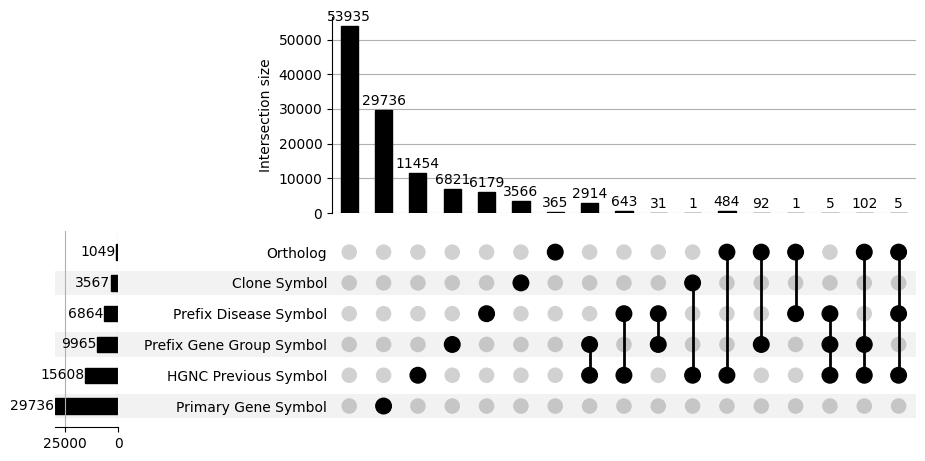

In [265]:
upset = UpSet(combination_counts, show_counts=True)
upset.plot()

#### <a id='toc6_1_4_5_'></a>[Which gene concepts have different primary gene symbol across the dbs?](#toc0_)

In [266]:
primary_symbols_analysis_capture_df = capture_df.copy()
# Step 1: Convert sets in 'Column 1' to frozensets for grouping
primary_symbols_analysis_capture_df['HGNC_ID'] = primary_symbols_analysis_capture_df['HGNC_ID'].apply(frozenset)

# Step 2: Remove rows with empty sets
primary_symbols_analysis_capture_df = primary_symbols_analysis_capture_df[primary_symbols_analysis_capture_df['HGNC_ID'].apply(lambda x: bool(x))]  # Exclude empty frozensets

# Step 2: Identify the sets where there are multiple distinct values in 'Column 3'
# Group by 'Column 1' and check for multiple unique values in 'Column 3'
grouped_primary_symbols_analysis_capture_df = primary_symbols_analysis_capture_df.groupby('HGNC_ID')['primary_gene_symbol'].nunique()

# Step 3: Filter for groups where there are more than 1 unique value in 'Column 3'
filter_sets = grouped_primary_symbols_analysis_capture_df[grouped_primary_symbols_analysis_capture_df > 1].index

# Step 4: Filter the original DataFrame for rows where 'Column 1' is in those sets
filtered_primary_symbols_analysis_capture_df = primary_symbols_analysis_capture_df[primary_symbols_analysis_capture_df['HGNC_ID'].isin(filter_sets)]

# Display the result
filtered_primary_symbols_analysis_capture_df


,HGNC_ID,ENSG_ID,NCBI_ID,primary_gene_symbol,gene_symbols,captured,captured as:
825,(HGNC:13708),{ENSG00000166856},{GENE ID:11318},ACKR5,7TMR,F,None
826,(HGNC:13708),{ENSG00000166856},{GENE ID:11318},ACKR5,ACKR5,T,Primary Gene Symbol
827,(HGNC:13708),{ENSG00000166856},{GENE ID:11318},ACKR5,ADMR,F,None
828,(HGNC:13708),{ENSG00000166856},{GENE ID:11318},ACKR5,AM-R,F,None
829,(HGNC:13708),{ENSG00000166856},{GENE ID:11318},ACKR5,AMR,F,None
...,...,...,...,...,...,...,...
112605,(HGNC:21668),{ENSG00000250535},{GENE ID:373159},WHR1B,BPG116M5.10,F,None
112606,(HGNC:21668),{ENSG00000250535},{GENE ID:373159},WHR1B,RP2,F,None
112607,(HGNC:21668),{},{GENE ID:373159},WHR1B,STK19B,F,None
112608,(HGNC:21668),{},{GENE ID:373159},WHR1B,STK19P,F,None


In [268]:
filtered_primary_symbols_analysis_capture_df = filtered_primary_symbols_analysis_capture_df.drop_duplicates(subset='primary_gene_symbol')
filtered_primary_symbols_analysis_capture_df = filtered_primary_symbols_analysis_capture_df.sort_values(by='HGNC_ID', ascending=True)
filtered_primary_symbols_analysis_capture_df

,HGNC_ID,ENSG_ID,NCBI_ID,primary_gene_symbol,gene_symbols,captured,captured as:
825,(HGNC:13708),{ENSG00000166856},{GENE ID:11318},ACKR5,7TMR,F,None
67572,(HGNC:8226),{ENSG00000180042},{GENE ID:9596},OR1R1P,OR17-1,T,Prefix Gene Group Symbol
67672,(HGNC:13968),{ENSG00000182477},{GENE ID:65944},OR2B8,DJ313I6.4,F,None
67677,(HGNC:13968),{ENSG00000182477},{GENE ID:65944},OR2B8P,HS6M1-29P,F,None
67751,(HGNC:8258),{ENSG00000237988},{GENE ID:442197},OR2I1,HS6M1-14,F,None
...,...,...,...,...,...,...,...
47100,(HGNC:49686),{ENSG00000281769},{GENE ID:102800446},LINC-ADAIN,LINC-ADAIN,T,Primary Gene Symbol
47957,(HGNC:49686),{ENSG00000281769},{},LINC01230,LINC-DMRT2,F,None
48064,(HGNC:50688),{ENSG00000185847},{GENE ID:100131138},LINC01405,LINC01405,T,Primary Gene Symbol
35841,(HGNC:6041),{ENSG00000105135},{GENE ID:10994},HACL2,209L8,F,None


here is where i stopped because idk if i need to do this with all ids? and how do i cross ref them?

In [269]:
capture_df.loc[capture_df["captured as:"]=="Prefix Gene Group Symbol, Primary Gene Symbol"]

,HGNC_ID,ENSG_ID,NCBI_ID,primary_gene_symbol,gene_symbols,captured,captured as:


In [271]:
capture_df.loc[capture_df["primary_gene_symbol"]=="ABHD11"]

,HGNC_ID,ENSG_ID,NCBI_ID,primary_gene_symbol,gene_symbols,captured,captured as:
444,{HGNC:16407},{ENSG00000106077},{GENE ID:83451},ABHD11,ABHD11,T,Primary Gene Symbol
445,{HGNC:16407},{ENSG00000106077},{GENE ID:83451},ABHD11,PP1226,F,None
446,{HGNC:16407},{ENSG00000106077},{GENE ID:83451},ABHD11,WBSCR21,T,HGNC Previous Symbol
